In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from qiskit_optimization.applications import Tsp
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA, SPSA, ADAM
from qiskit.primitives import Sampler
from qiskit_optimization import QuadraticProgram
import random
import time

In [3]:
def draw_graph(G, path=None):
    pos = nx.spring_layout(G)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    colors = ['red' if node in path else 'lightblue' for node in G.nodes()] if path else 'lightblue'

    nx.draw_networkx(G, pos, node_color=colors, with_labels=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels)

    if path:
        edge_path = [(path[i], path[(i+1)%len(path)]) for i in range(len(path))]
        nx.draw_networkx_edges(G, pos, edgelist=edge_path, edge_color='blue', width=2)
        
    plt.show()

In [ ]:
def tsp_solver(tsp_custom, qp ):
    sampler = Sampler()
    qaoa = QAOA(sampler=sampler, optimizer=COBYLA(), reps=1)

    qaoa_optimizer = MinimumEigenOptimizer(qaoa)

    quantum_result = qaoa_optimizer.solve(qp)
    quantum_path = tsp_custom.interpret(quantum_result.x)

    return quantum_result.fval, quantum_path      

In [5]:
def tsp_solver_qubo(tsp_custom, qp):
    sampler = Sampler()
    qaoa_cost_history = []

    def callback_fn(eval_count, params, mean, norm, accepted):
        qaoa_cost_history.append(mean)
        print(f"Step {eval_count}, Cost: {mean}, Norm: {norm}, Accepted: {accepted}")

    qubo = QuadraticProgramToQubo()
    qubo_converter = qubo.convert(qp)

    qaoa = QAOA(sampler=sampler, optimizer=SPSA(maxiter = 100, callback = callback_fn))

    qaoa_optimizer = MinimumEigenOptimizer(qaoa)

    quantum_result = qaoa_optimizer.solve(qubo_converter)    
    quantum_path = tsp_custom.interpret(quantum_result.x)

    return quantum_result.fval, quantum_path, qaoa_cost_history        

In [6]:
def route_cost(path, dist_matrix):
    return sum(dist_matrix[path[i]][path[(i+1)%len(path)]] for i in range(len(path)))

In [8]:
def simulated_annealing(dist_matrix, temp=10000.0, cooling_rate=0.995, stopping_temp=1e-8, initial_solution=None):
    num_nodes = len(dist_matrix)
    if initial_solution is None:
        curr_solution = list(range(num_nodes))
    else:
        curr_solution = initial_solution[:]
    best_solution = curr_solution[:]
    best_cost = route_cost(curr_solution, dist_matrix)
    cost_history = [best_cost]

    while temp > stopping_temp:
        new_solution = curr_solution[:]
        i, j = random.sample(range(num_nodes), 2)
        new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
        new_cost = route_cost(new_solution, dist_matrix)
        
        if new_cost < best_cost or random.random() < np.exp((best_cost - new_cost) / temp):
            curr_solution = new_solution[:]
            if new_cost < best_cost:
                best_solution = new_solution[:]
                best_cost = new_cost
                cost_history.append(best_cost)
                
        temp *= cooling_rate

    return best_solution, best_cost, cost_history

In [ ]:
def hybrid_solver(tsp_custom, qp, dist_matrix, iterations=3):
    
    best_path, best_cost, sa_history = simulated_annealing(dist_matrix)
    print("Initial candidate from Simulated Annealing:")
    print("Path:", best_path, "Cost:", best_cost)
    hybrid_history = [best_cost]
    
    for it in range(iterations):
        print(f"\nHybrid Iteration {it+1}:")
    
        obj_quantum, q_path = tsp_solver(tsp_custom, qp)
        print("Quantum candidate (QAOA):")
        print("Path:", q_path, "Cost:", obj_quantum)
    
        if obj_quantum < best_cost:
            best_cost = obj_quantum
            best_path = q_path[:]
        
        new_path, new_cost, _ = simulated_annealing(dist_matrix, initial_solution=best_path)
        print("Refined candidate (Simulated Annealing):")
        print("Path:", new_path, "Cost:", new_cost)
        if new_cost < best_cost:
            best_cost = new_cost
            best_path = new_path[:]
        hybrid_history.append(best_cost)
    
    return best_path, best_cost, hybrid_history

## 4 nodes

In [9]:
custom_matrix = np.array([
    [0, 2, 9, 10],
    [2, 0, 7, 4],
    [9, 7, 0, 8],
    [10, 4, 8, 0]
])

n_nodes = custom_matrix.shape[0]

In [10]:
G_custom = nx.complete_graph(n_nodes)


In [11]:
for i, j in G_custom.edges():
    G_custom[i][j]['weight'] = custom_matrix[i][j]

In [12]:
tsp_custom = Tsp(G_custom)

In [13]:
graph = tsp_custom.graph

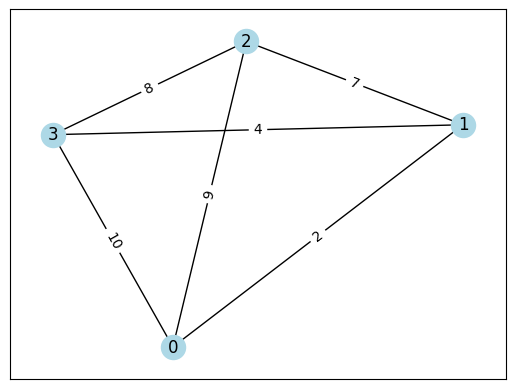

In [14]:
draw_graph(graph)


In [18]:
qp = tsp_custom.to_quadratic_program()

In [41]:
qaoa = QAOA(sampler=Sampler(), optimizer=COBYLA(), reps=1)

qp_solver = MinimumEigenOptimizer(qaoa)
qp_result = qp_solver.solve(qp)

qc = qaoa.ansatz

In [ ]:
qaoa_start = time.time()
obj, path = tsp_solver(tsp_custom, qp)
qaoa_end = time.time()

print(f"QAOA Time: {qaoa_end - qaoa_start:.4f} seconds")
print(f"QAOA Solution: {path}\n Cost: {obj}")

QAOA Time: 226.9048 seconds
QAOA Solution: [3, 2, 0, 1]
 Cost: 23.0


Step 3, Cost: 233.69319871599944, Norm: 0.40615579259358464, Accepted: True
Step 6, Cost: 387.8722134435071, Norm: 0.25750379926371914, Accepted: True
Step 9, Cost: 21.371028175799054, Norm: 1.0138010246048812, Accepted: True
Step 12, Cost: 709.845351607552, Norm: 18.85753800622198, Accepted: True
Step 15, Cost: 41.7982874295244, Norm: 0.7821040400491325, Accepted: True
Step 18, Cost: -9.749997408160622, Norm: 0.2848910221102469, Accepted: True
Step 21, Cost: -128.08642759101963, Norm: 0.11961816211336343, Accepted: True
Step 24, Cost: 621.927217708531, Norm: 0.5152547384498085, Accepted: True
Step 27, Cost: -3.9079156974980656, Norm: 2.694389514511236, Accepted: True
Step 30, Cost: -1.1336349880223875, Norm: 0.15001479634639184, Accepted: True
Step 33, Cost: 0.012608197061227233, Norm: 0.25672104833015114, Accepted: True
Step 36, Cost: 78.16879371537249, Norm: 0.25953612944818466, Accepted: True
Step 39, Cost: -1.1251173537809747, Norm: 0.01528202206791592, Accepted: True
Step 42, Cos

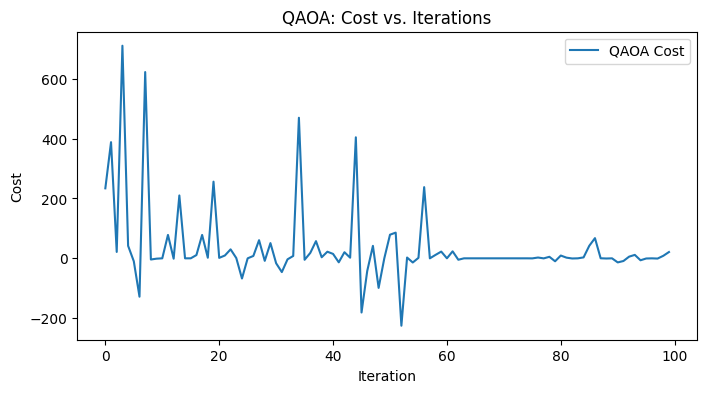

In [54]:
qaoa_qubo_start = time.time()
obj_qubo, path_qubo, qaoa_cost_history = tsp_solver_qubo(tsp_custom, qp)
qaoa_qubo_end = time.time()

print(f"QAOA QUBO Time: {qaoa_qubo_end - qaoa_qubo_start:.4f} seconds")
print(f"QAOA Solution: {path_qubo}\n Cost: {obj_qubo}")

plt.figure(figsize=(8, 4))
plt.plot(qaoa_cost_history, label='QAOA Cost')
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("QAOA: Cost vs. Iterations")
plt.legend()
plt.show()

Simulated Annealing Time: 0.0487 seconds
Simulated Annealing Solution: [2, 0, 1, 3]
 Cost: 23


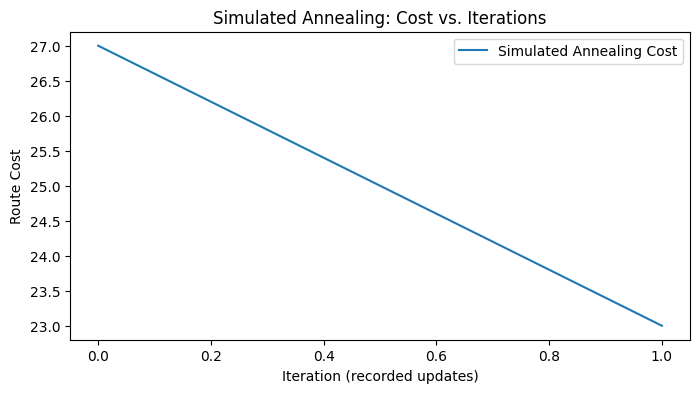

In [16]:
sa_start = time.time()
classic_path, classic_cost, sa_cost_history = simulated_annealing(custom_matrix)
sa_end = time.time()

print(f"Simulated Annealing Time: {sa_end - sa_start:.4f} seconds")
print(f"Simulated Annealing Solution: {classic_path}\n Cost: {classic_cost}")

plt.figure(figsize=(8, 4))
plt.plot(sa_cost_history, label='Simulated Annealing Cost')
plt.xlabel("Iteration (recorded updates)")
plt.ylabel("Route Cost")
plt.title("Simulated Annealing: Cost vs. Iterations")
plt.legend()
plt.show()

Initial candidate from Simulated Annealing:
Path: [3, 2, 0, 1] Cost: 23

Hybrid Iteration 1:
Quantum candidate (QAOA):
Path: [3, 2, 0, 1] Cost: 23.0
Refined candidate (Simulated Annealing):
Path: [3, 2, 0, 1] Cost: 23

Hybrid Iteration 2:
Quantum candidate (QAOA):
Path: [3, 2, 0, 1] Cost: 23.0
Refined candidate (Simulated Annealing):
Path: [3, 2, 0, 1] Cost: 23

Hybrid Iteration 3:
Quantum candidate (QAOA):
Path: [3, 2, 0, 1] Cost: 23.0
Refined candidate (Simulated Annealing):
Path: [3, 2, 0, 1] Cost: 23
Hybrid Solver Time: 819.0434 seconds
Hybrid Path: [3, 2, 0, 1]
Hybrid Cost: 23


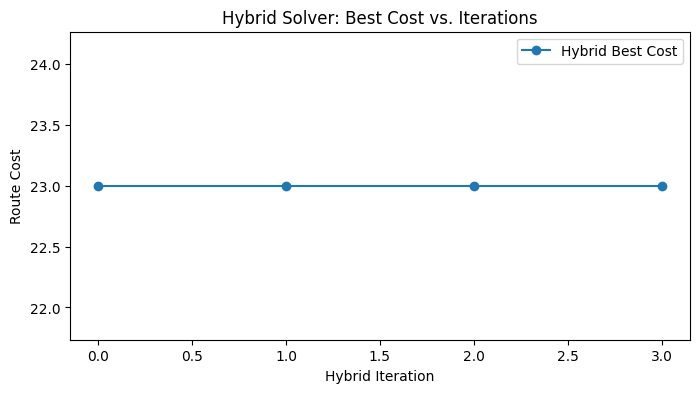

In [ ]:
start = time.time()
hybrid_path, hybrid_cost, hybrid_history = hybrid_solver(tsp_custom, qp, custom_matrix, iterations=3)
end = time.time()

print("--------------------------------------------------------")
print(f"Hybrid Solver Time: {end - start:.4f} seconds")
print("Hybrid Path:", hybrid_path)
print("Hybrid Cost:", hybrid_cost)

plt.figure(figsize=(8, 4))
plt.plot(hybrid_history, marker='o', label='Hybrid Best Cost')
plt.xlabel("Hybrid Iteration")
plt.ylabel("Route Cost")
plt.title("Hybrid Solver: Best Cost vs. Iterations")
plt.legend()
plt.show()


Visualizing Quantum Route:


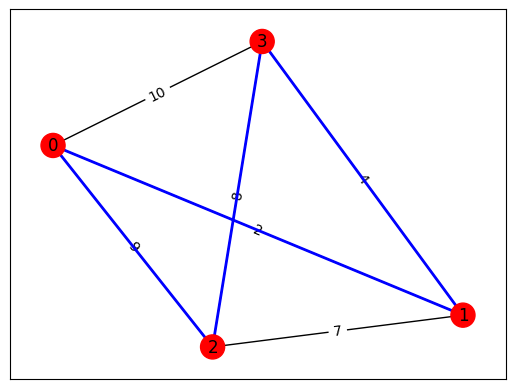


Visualizing Classical Route:


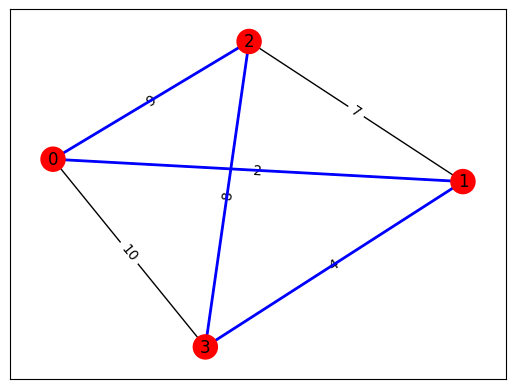


Visualizing Hybrid Route:


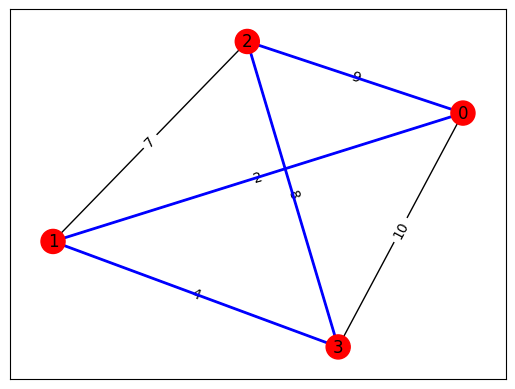

In [23]:
print("\nVisualizing Quantum Route:")
draw_graph(graph, path=path)

print("\nVisualizing Classical Route:")
draw_graph(graph, path=classic_path)

print("\nVisualizing Hybrid Route:")
draw_graph(graph, path=hybrid_path)

## For 4 complex Nodes

In [48]:
n_cities = 4
random_seed = 12

In [49]:
tsp = Tsp.create_random_instance(n_cities, seed=random_seed)
tsp_graph = tsp.graph
matrix = nx.to_numpy_array(tsp_graph)
print("Adjacency Matrix:\n", matrix)

Adjacency Matrix:
 [[ 0. 77. 72. 93.]
 [77.  0. 17. 49.]
 [72. 17.  0. 34.]
 [93. 49. 34.  0.]]


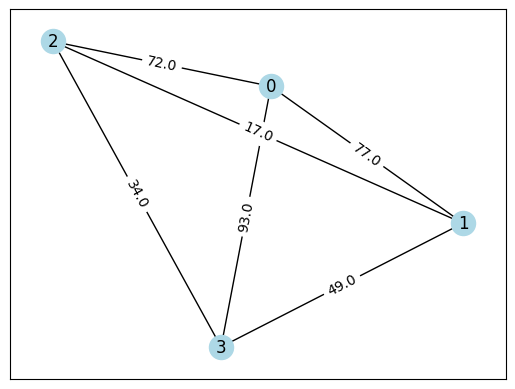

In [50]:
draw_graph(tsp_graph)

In [51]:
tsp_quadratic_program = tsp.to_quadratic_program()

In [52]:
obj_4, path_4 = tsp_solver(tsp, tsp_quadratic_program)
print(f"QAOA Solution for 4 cities: {path_4}\n Cost: {obj_4}")

QAOA Solution for 4 cities: [3, 2, 1, 0]
 Cost: 221.0


In [54]:
classic_path_, classic_cost_ = simulated_annealing(matrix)

print("Classical (Simulated Annealing) Solution:", classic_path_)
print("Classical Cost:", classic_cost_)

Classical (Simulated Annealing) Solution: [0, 1, 2, 3]
Classical Cost: 221.0



Visualizing Quantum Route:


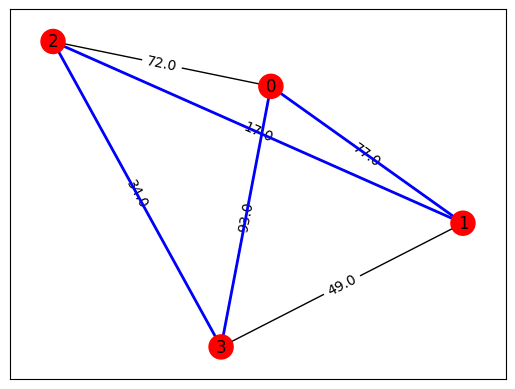


Visualizing Classical Route:


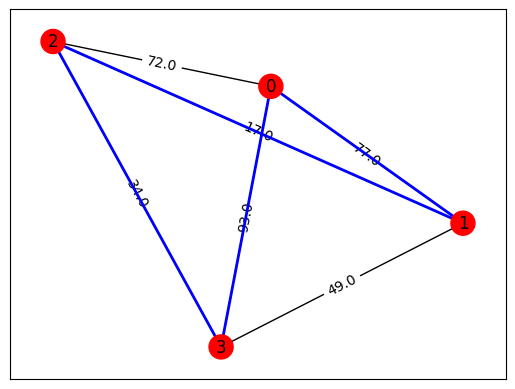

In [55]:
print("\nVisualizing Quantum Route:")
draw_graph(tsp_graph, path=path_4)

print("\nVisualizing Classical Route:")
draw_graph(tsp_graph, path=classic_path_)


## For another 4 nodes

In [57]:
matrix_ = np.array([[ 0, 48, 91, 33],
 [48. , 0. ,63. ,71.],
 [91. ,63. , 0., 92.],
 [33., 71., 92.,  0.]])

In [58]:
n_nodes_ = matrix_.shape[0]

In [60]:
G_custom_ = nx.complete_graph(n_nodes_)


In [61]:
for i, j in G_custom_.edges():
    G_custom_[i][j]['weight'] = matrix_[i][j]

In [62]:
tsp_custom_ = Tsp(G_custom_)

In [63]:
graph_ = tsp_custom_.graph

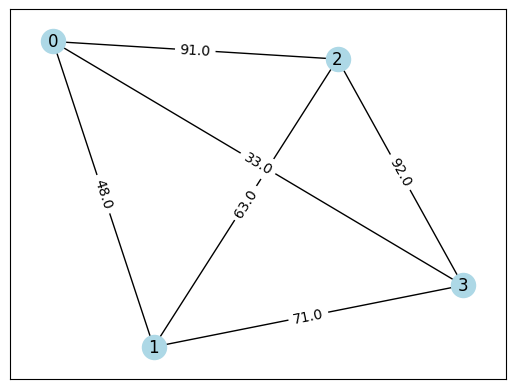

In [64]:
draw_graph(graph_)

In [65]:
qp_ = tsp_custom_.to_quadratic_program()

In [66]:
obj_1, path_1 = tsp_solver(tsp_custom_, qp_)
print(f"QAOA Solution: {path_1}\n Cost: {obj_1}")

QAOA Solution: [3, 2, 1, 0]
 Cost: 236.0


In [67]:
classic_path_1, classic_cost_1 = simulated_annealing(matrix_)

print("Classical (Simulated Annealing) Solution:", classic_path_1)
print("Classical Cost:", classic_cost_1)

Classical (Simulated Annealing) Solution: [0, 1, 2, 3]
Classical Cost: 236.0



Visualizing Quantum Route:


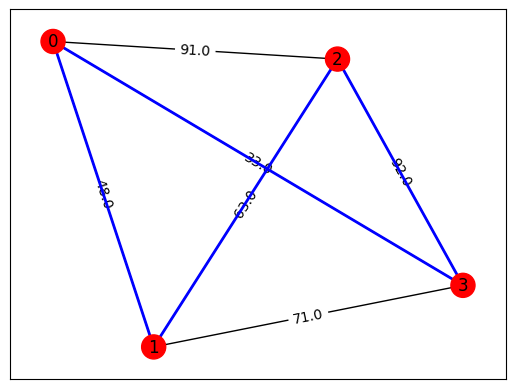


Visualizing Classical Route:


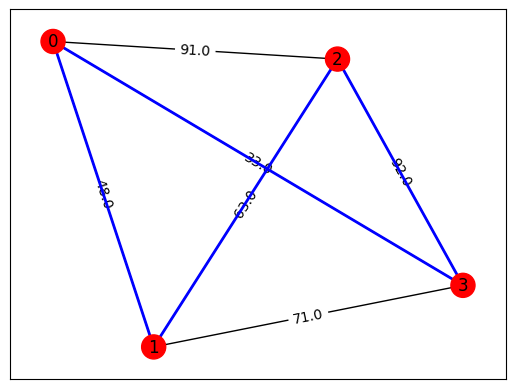

In [68]:
print("\nVisualizing Quantum Route:")
draw_graph(graph_, path=path_1)

print("\nVisualizing Classical Route:")
draw_graph(graph_, path=classic_path_1)


## QUBO Optimisation

In [16]:
print(qp.prettyprint())

Problem name: TSP

Minimize
  2*x_0_0*x_1_1 + 2*x_0_0*x_1_3 + 9*x_0_0*x_2_1 + 9*x_0_0*x_2_3 + 10*x_0_0*x_3_1
  + 10*x_0_0*x_3_3 + 2*x_0_1*x_1_0 + 2*x_0_1*x_1_2 + 9*x_0_1*x_2_0
  + 9*x_0_1*x_2_2 + 10*x_0_1*x_3_0 + 10*x_0_1*x_3_2 + 2*x_0_2*x_1_1
  + 2*x_0_2*x_1_3 + 9*x_0_2*x_2_1 + 9*x_0_2*x_2_3 + 10*x_0_2*x_3_1
  + 10*x_0_2*x_3_3 + 2*x_0_3*x_1_0 + 2*x_0_3*x_1_2 + 9*x_0_3*x_2_0
  + 9*x_0_3*x_2_2 + 10*x_0_3*x_3_0 + 10*x_0_3*x_3_2 + 6*x_1_0*x_2_1
  + 6*x_1_0*x_2_3 + 4*x_1_0*x_3_1 + 4*x_1_0*x_3_3 + 6*x_1_1*x_2_0
  + 6*x_1_1*x_2_2 + 4*x_1_1*x_3_0 + 4*x_1_1*x_3_2 + 6*x_1_2*x_2_1
  + 6*x_1_2*x_2_3 + 4*x_1_2*x_3_1 + 4*x_1_2*x_3_3 + 6*x_1_3*x_2_0
  + 6*x_1_3*x_2_2 + 4*x_1_3*x_3_0 + 4*x_1_3*x_3_2 + 8*x_2_0*x_3_1
  + 8*x_2_0*x_3_3 + 8*x_2_1*x_3_0 + 8*x_2_1*x_3_2 + 8*x_2_2*x_3_1
  + 8*x_2_2*x_3_3 + 8*x_2_3*x_3_0 + 8*x_2_3*x_3_2

Subject to
  Linear constraints (8)
    x_0_0 + x_0_1 + x_0_2 + x_0_3 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 + x_1_3 == 1  'c1'
    x_2_0 + x_2_1 + x_2_2 + x_2_3 == 1  'c2'
  

In [17]:
qubo = QuadraticProgramToQubo()
qubo_version = qubo.convert(qp)

In [18]:
print(qubo_version.prettyprint())

Problem name: TSP

Minimize
  626*x_0_0^2 + 626*x_0_0*x_0_1 + 626*x_0_0*x_0_2 + 626*x_0_0*x_0_3
  + 626*x_0_0*x_1_0 + 2*x_0_0*x_1_1 + 2*x_0_0*x_1_3 + 626*x_0_0*x_2_0
  + 9*x_0_0*x_2_1 + 9*x_0_0*x_2_3 + 626*x_0_0*x_3_0 + 10*x_0_0*x_3_1
  + 10*x_0_0*x_3_3 + 626*x_0_1^2 + 626*x_0_1*x_0_2 + 626*x_0_1*x_0_3
  + 2*x_0_1*x_1_0 + 626*x_0_1*x_1_1 + 2*x_0_1*x_1_2 + 9*x_0_1*x_2_0
  + 626*x_0_1*x_2_1 + 9*x_0_1*x_2_2 + 10*x_0_1*x_3_0 + 626*x_0_1*x_3_1
  + 10*x_0_1*x_3_2 + 626*x_0_2^2 + 626*x_0_2*x_0_3 + 2*x_0_2*x_1_1
  + 626*x_0_2*x_1_2 + 2*x_0_2*x_1_3 + 9*x_0_2*x_2_1 + 626*x_0_2*x_2_2
  + 9*x_0_2*x_2_3 + 10*x_0_2*x_3_1 + 626*x_0_2*x_3_2 + 10*x_0_2*x_3_3
  + 626*x_0_3^2 + 2*x_0_3*x_1_0 + 2*x_0_3*x_1_2 + 626*x_0_3*x_1_3
  + 9*x_0_3*x_2_0 + 9*x_0_3*x_2_2 + 626*x_0_3*x_2_3 + 10*x_0_3*x_3_0
  + 10*x_0_3*x_3_2 + 626*x_0_3*x_3_3 + 626*x_1_0^2 + 626*x_1_0*x_1_1
  + 626*x_1_0*x_1_2 + 626*x_1_0*x_1_3 + 626*x_1_0*x_2_0 + 6*x_1_0*x_2_1
  + 6*x_1_0*x_2_3 + 626*x_1_0*x_3_0 + 4*x_1_0*x_3_1 + 4*x_1_0*x_3_3
  + 62

In [20]:
op,offset=qubo_version.to_ising()
print(f"Offest : ",offset)
print("Ising Hamiltonian  : ")
print(op)

Offest :  5086.0
Ising Hamiltonian  : 
SparsePauliOp(['IIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIZII', 'IIIIIIIIIIIIZIII', 'IIIIIIIIIIIZIIII', 'IIIIIIIIIIZIIIII', 'IIIIIIIIIZIIIIII', 'IIIIIIIIZIIIIIII', 'IIIIIIIZIIIIIIII', 'IIIIIIZIIIIIIIII', 'IIIIIZIIIIIIIIII', 'IIIIZIIIIIIIIIII', 'IIIZIIIIIIIIIIII', 'IIZIIIIIIIIIIIII', 'IZIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIZIZ', 'IIIIIIIIIIIIZIIZ', 'IIIIIIIIIIIZIIIZ', 'IIIIIIIIIIZIIIIZ', 'IIIIIIIIZIIIIIIZ', 'IIIIIIIZIIIIIIIZ', 'IIIIIIZIIIIIIIIZ', 'IIIIZIIIIIIIIIIZ', 'IIIZIIIIIIIIIIIZ', 'IIZIIIIIIIIIIIIZ', 'ZIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIZIZI', 'IIIIIIIIIIIZIIZI', 'IIIIIIIIIIZIIIZI', 'IIIIIIIIIZIIIIZI', 'IIIIIIIZIIIIIIZI', 'IIIIIIZIIIIIIIZI', 'IIIIIZIIIIIIIIZI', 'IIIZIIIIIIIIIIZI', 'IIZIIIIIIIIIIIZI', 'IZIIIIIIIIIIIIZI', 'IIIIIIIIIIIIZZII', 'IIIIIIIIIIZIIZII', 'IIIIIIIIIZIIIZII', 'IIIIIIIIZIIIIZII', 'IIIIIIZIIIIIIZII', 'IIIIIZIIIIIIIZII', 'IIIIZIIIIIIIIZII', 'IIZIIIIIIIIIIZII', 'IZIII

In [21]:
qa=MinimumEigenOptimizer(QAOA(sampler=Sampler(),optimizer=COBYLA()))
rslt=qa.solve(qubo_version)
print(rslt.prettyprint())

objective function value: 23.0
variable values: x_0_0=0.0, x_0_1=0.0, x_0_2=1.0, x_0_3=0.0, x_1_0=0.0, x_1_1=0.0, x_1_2=0.0, x_1_3=1.0, x_2_0=0.0, x_2_1=1.0, x_2_2=0.0, x_2_3=0.0, x_3_0=1.0, x_3_1=0.0, x_3_2=0.0, x_3_3=0.0
status: SUCCESS


In [23]:
qubo_path = tsp_custom.interpret(rslt.x)
print("QAOA Solution: ",qubo_path)
print("Cost: ",rslt.fval+offset)

QAOA Solution:  [3, 2, 0, 1]
Cost:  5109.0


## SPSA Optimiser

In [26]:
print(qp.prettyprint())

Problem name: TSP

Minimize
  2*x_0_0*x_1_1 + 2*x_0_0*x_1_3 + 9*x_0_0*x_2_1 + 9*x_0_0*x_2_3 + 10*x_0_0*x_3_1
  + 10*x_0_0*x_3_3 + 2*x_0_1*x_1_0 + 2*x_0_1*x_1_2 + 9*x_0_1*x_2_0
  + 9*x_0_1*x_2_2 + 10*x_0_1*x_3_0 + 10*x_0_1*x_3_2 + 2*x_0_2*x_1_1
  + 2*x_0_2*x_1_3 + 9*x_0_2*x_2_1 + 9*x_0_2*x_2_3 + 10*x_0_2*x_3_1
  + 10*x_0_2*x_3_3 + 2*x_0_3*x_1_0 + 2*x_0_3*x_1_2 + 9*x_0_3*x_2_0
  + 9*x_0_3*x_2_2 + 10*x_0_3*x_3_0 + 10*x_0_3*x_3_2 + 6*x_1_0*x_2_1
  + 6*x_1_0*x_2_3 + 4*x_1_0*x_3_1 + 4*x_1_0*x_3_3 + 6*x_1_1*x_2_0
  + 6*x_1_1*x_2_2 + 4*x_1_1*x_3_0 + 4*x_1_1*x_3_2 + 6*x_1_2*x_2_1
  + 6*x_1_2*x_2_3 + 4*x_1_2*x_3_1 + 4*x_1_2*x_3_3 + 6*x_1_3*x_2_0
  + 6*x_1_3*x_2_2 + 4*x_1_3*x_3_0 + 4*x_1_3*x_3_2 + 8*x_2_0*x_3_1
  + 8*x_2_0*x_3_3 + 8*x_2_1*x_3_0 + 8*x_2_1*x_3_2 + 8*x_2_2*x_3_1
  + 8*x_2_2*x_3_3 + 8*x_2_3*x_3_0 + 8*x_2_3*x_3_2

Subject to
  Linear constraints (8)
    x_0_0 + x_0_1 + x_0_2 + x_0_3 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 + x_1_3 == 1  'c1'
    x_2_0 + x_2_1 + x_2_2 + x_2_3 == 1  'c2'
  

In [ ]:
qaoa_spsa = MinimumEigenOptimizer(QAOA(sampler=Sampler(), optimizer=SPSA(), reps=3))    

In [28]:
qubo_path_spsa = tsp_custom.interpret(qaoa_spsa.solve(qp).x)
print("QAOA Solution with SPSA: ", qubo_path_spsa)

QAOA Solution with COBYLA:  [3, 2, 0, 1]


### QAOA Circuit Diagram

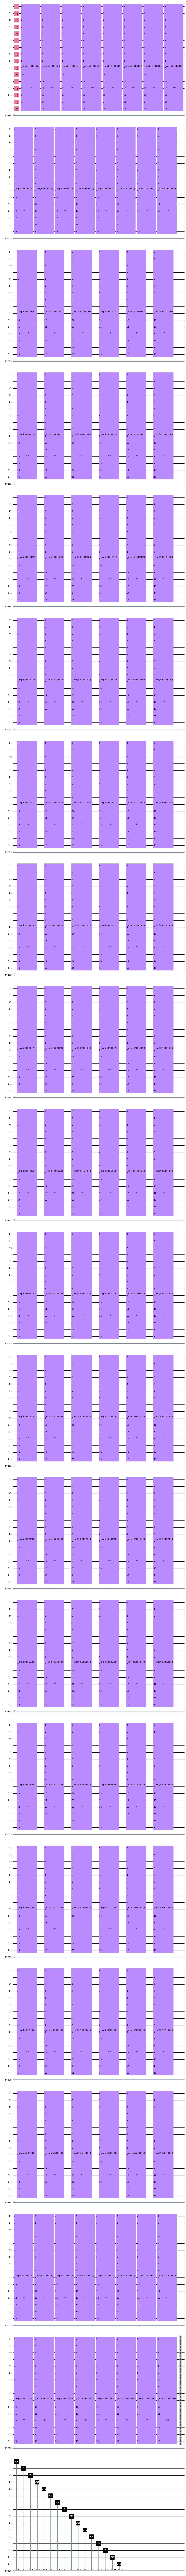

In [44]:
qc.decompose().draw('mpl')

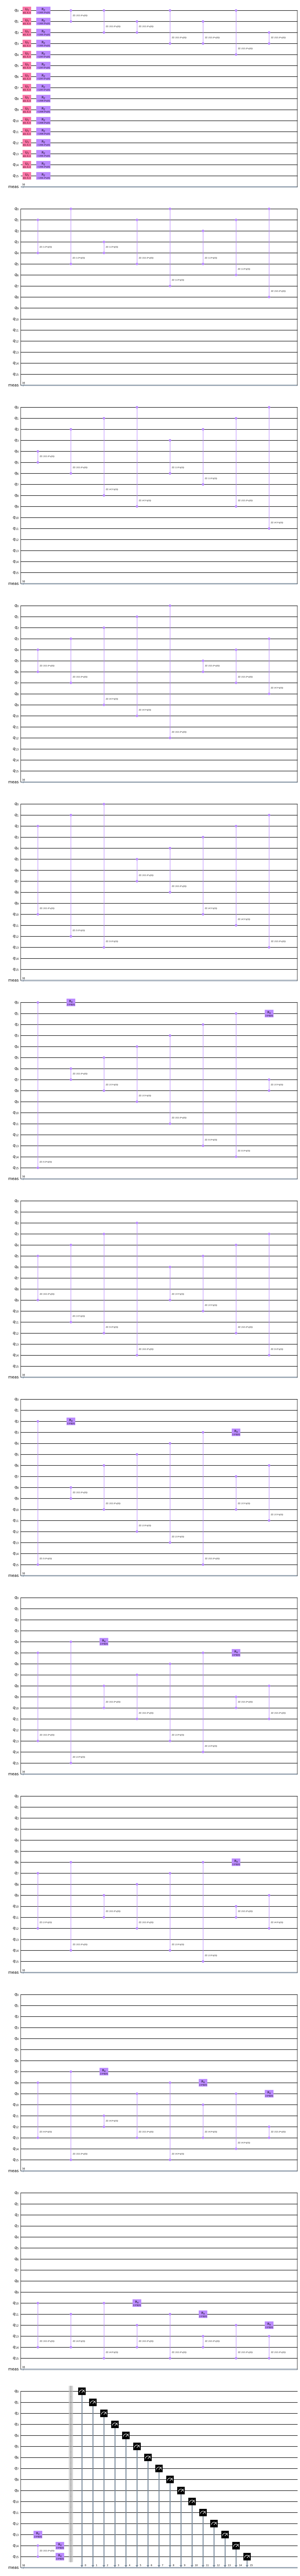

In [45]:
qc.decompose().decompose().draw('mpl')